# Machine Failure Classification

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.decomposition import PCA

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif


from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Functions

In [12]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
    
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', model)])
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def get_over_sampling_methods(X, y, name):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  smapling_model = sampling_models[name]
  X_res, y_res = smapling_model.fit_resample(X, y)
  
  return (X_res, y_res)

# EDA Analysis

In [5]:
df = pd.read_csv("/Users/maukanmir/Downloads/machine_failure_cleaned.csv")
df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9810,1604,29.5,14,0,0,0,0,0
9811,1632,31.8,17,0,0,0,0,0
9812,1645,33.4,22,0,0,0,0,0
9813,1408,48.5,25,0,0,0,0,0


# Check For Nulls and Dupes

In [6]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: Rotational speed [rpm]    0
Torque [Nm]               0
Tool wear [min]           0
TWF                       0
HDF                       0
PWF                       0
OSF                       0
Machine failure           0
dtype: int64
Dupe Count: 6


In [7]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

Class=0, Count=9523, Percentage=97.084%
Class=1, Count=286, Percentage=2.916%


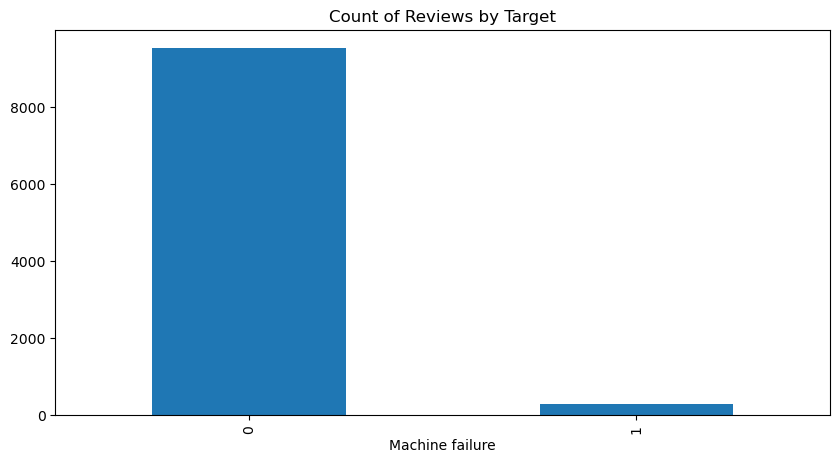

In [8]:
check_class_imbalance(df,df['Machine failure'], 'Machine failure')

# Extreme Class Imbalance which will have to be addressed through sampling methods

In [9]:
df.dtypes

Rotational speed [rpm]      int64
Torque [Nm]               float64
Tool wear [min]             int64
TWF                         int64
HDF                         int64
PWF                         int64
OSF                         int64
Machine failure             int64
dtype: object

In [10]:
df.describe()

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
count,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000
mean,1526.408095,40.329728,107.926802,0.004486,0.011724,0.004486,0.009583,0.029157
std,147.339453,9.422408,63.605989,0.066828,0.107646,0.066828,0.097428,0.168255
min,1168.000000,16.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1422.000000,33.600000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1501.000000,40.200000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1606.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2076.000000,68.900000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Visuals

<AxesSubplot:>

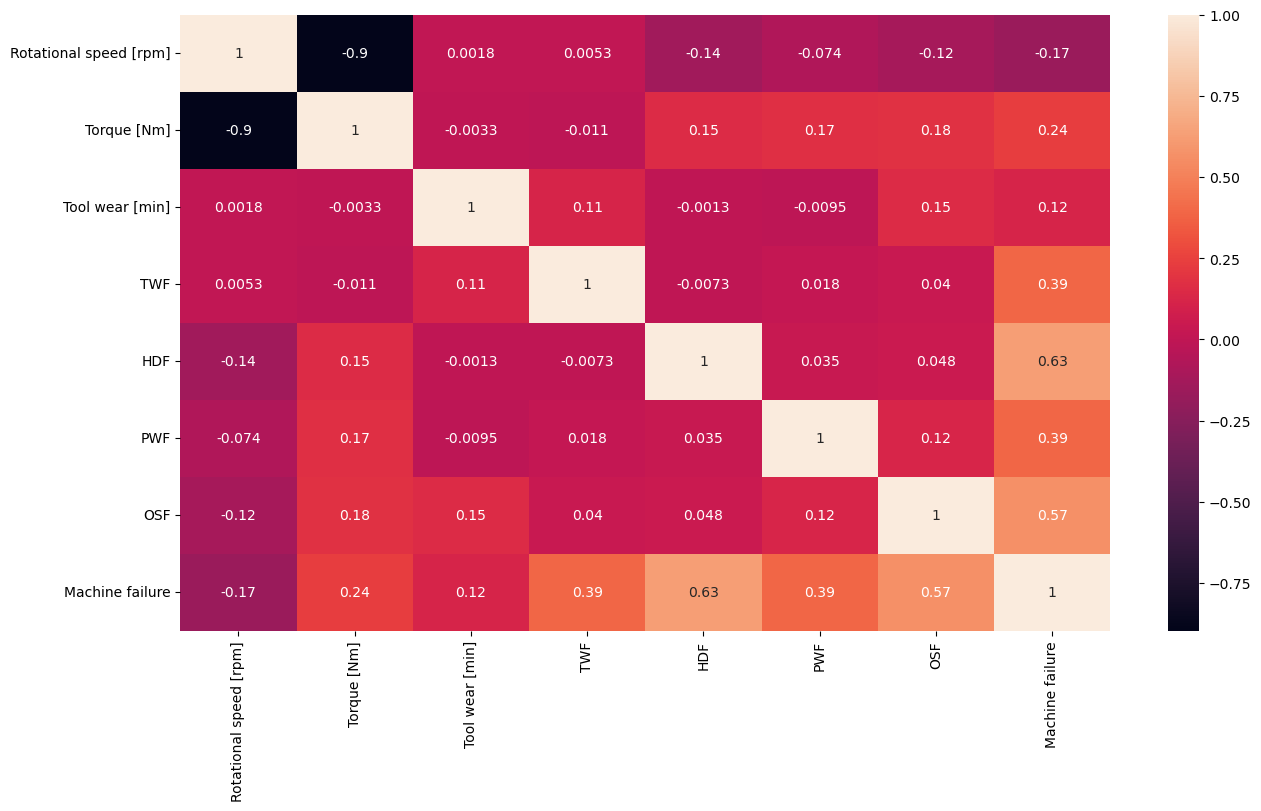

In [11]:
plt.figure(figsize=(15,8))
sns.heatmap(data=df.corr(), annot=True)

# Lot of high correlations with a dataset that has only 8 columns is a great sign

<AxesSubplot:xlabel='Machine failure', ylabel='HDF'>

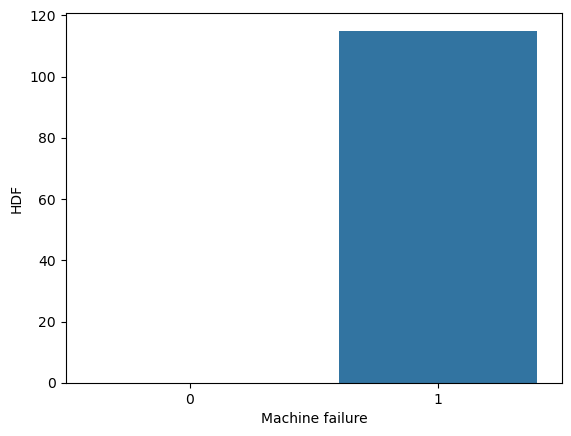

In [14]:

grouped_by_HDF = df.groupby("Machine failure")["HDF"].sum().reset_index()

sns.barplot(data=grouped_by_HDF, x="Machine failure", y="HDF")

# Separate Features

In [15]:

X,y = df.drop("Machine failure", axis=1), df['Machine failure']

# Baseline Model Metrics

In [16]:
model = DummyClassifier(strategy="constant", constant=1)
scores = evaluate_model(X,y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.057 (0.000)


# Advanced Model Metrics

In [17]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
0,LDA,0.98389,0.010017
1,LR,0.98389,0.010017
2,SVC,0.98389,0.010017
3,GNB,0.98389,0.010017
4,GPC,0.98389,0.010017


In [18]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
0,RFC,0.983890,0.010017
2,XGB,0.983310,0.010848
3,GBC,0.979333,0.011877
1,DTC,0.960274,0.019523


# The model is overfitting, due to severe class imbalance

# SMOTE Over sampling methods

In [19]:
X_smote, y_smote = get_over_sampling_methods(X, y, "SMOTE")

In [21]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
1,SVC,0.935379,0.004127
0,LR,0.915210,0.004392


In [22]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,RFC,0.967586,0.002149
2,XGB,0.964774,0.001871
1,DTC,0.958856,0.003219
3,GBC,0.944060,0.004364


# ADASYN

In [23]:

X_adasyn, y_adasyn = get_over_sampling_methods(X, y, "ADASYN")

In [24]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_adasyn, y_adasyn)

,Model,Mean,STD
1,SVC,0.926563,0.004626
0,LR,0.907296,0.004890


In [25]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_adasyn, y_adasyn)

,Model,Mean,STD
0,RFC,0.965513,0.002884
2,XGB,0.963583,0.002205
1,DTC,0.955524,0.003670
3,GBC,0.939297,0.003889


# Borderline SMOTE

In [26]:
X_bl, y_bl = get_over_sampling_methods(X, y, "BL-SMOTE")

In [28]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
1,SVC,0.960512,0.003562
0,LR,0.938013,0.003500


In [29]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
0,RFC,0.982089,0.002147
2,XGB,0.981669,0.001683
1,DTC,0.975776,0.002394
3,GBC,0.967618,0.003370


# KNN-SMOTE

In [30]:
X_knn, y_knn = get_over_sampling_methods(X, y, "KNN-SMOTE")

In [31]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

,Model,Mean,STD
1,SVC,0.935843,0.003080
0,LR,0.915550,0.003979


In [32]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

,Model,Mean,STD
0,RFC,0.966402,0.002104
2,XGB,0.964750,0.002334
1,DTC,0.957521,0.004644
3,GBC,0.941583,0.003011


# Borderline SMOTE has the best performance

# MLP Tuning

In [34]:
def create_keras_classifier(function, optimizer, idx, param, validation_data):
    if idx == 0 or idx ==3:
        
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    elif idx ==1:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
        
    else:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    return model

def create_model_dropout(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerl2(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerL1(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', activity_regularizer=l1(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_without_reg(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


X_train, X_temp, y_train, y_temp = train_test_split(X_bl, y_bl, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

functions = [
  create_model_dropout,
  create_model_regularizerL1,
  create_model_regularizerl2,
  create_model_without_reg
]

optimizers = [
    Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07),
    SGD(lr=0.01, momentum=0.9), 
    SGD(lr=0.001, momentum=0.9),
    ]
optimizer_names = ['Adam', "RmsProp", "SGD:0.01", "SGD:0.001"]
function_names = ["Dropout", "L1", "L2", 'Without_Reg']
values = [1e-1, 1e-2, 1e-3, 1e-4]
model_performance = []
for index, function in enumerate(functions):
    name = function_names[index]
    for idx, optimizer in enumerate(optimizers):
        optimizer_name = optimizer_names[idx]
        value = values[idx]
        model = create_keras_classifier(function, optimizer, index, value, (X_val, y_val))
        
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy,
            "Optimizer": optimizer_name,
            "Value": value
        })
model_df = pd.DataFrame(model_performance)
end_result = model_df.sort_values(by="Accuracy", ascending=False)
end_result

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_82070/1861942918.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
2024-05-06 20:52:54.829645: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_82070/1861942918.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
/var/folders/bb/2qsf8cm95jg05

,Model,Accuracy,Optimizer,Value
12,Without_Reg,0.963000,Adam,0.1000
0,Dropout,0.954624,Adam,0.1000
5,L1,0.952930,RmsProp,0.0100
13,Without_Reg,0.946485,RmsProp,0.0100
1,Dropout,0.941971,RmsProp,0.0100
9,L2,0.888652,RmsProp,0.0100
8,L2,0.881860,Adam,0.1000
2,Dropout,0.508994,SGD:0.01,0.0010
3,Dropout,0.508994,SGD:0.001,0.0001
6,L1,0.508994,SGD:0.01,0.0010


In [ ]:
model = create_model_without_reg(X_train.shape[1], "adam")
history = model.fit(X_train, y_train, epochs=50, bath_size=32, verbose=0, validation_data=(X_val, y_val))

